In [1]:
#!/usr/bin/python3
# -*-coding:utf-8
'''
Created on Fri Dec 1 22:22:35 2017

@author: Ray

'''
import warnings
warnings.filterwarnings("ignore")
from glob import glob
import gc
import os
from tqdm import tqdm
import time
from itertools import chain
import pandas as pd
import numpy as np
from xgboost import plot_importance
from xgboost import XGBClassifier
from matplotlib import pyplot
import utils # made by author for efficiently dealing with data

seed = 72
np.random.seed(seed)


In [3]:
##########################################
#load dataset
##########################################

# load dataset
file_name = '../output/model/xgb_feature_tuning_seed_72.model'
train_0 = utils.load_pred_feature('trainW-0', keep_all = False, model_file_name = file_name, n_top_features = 48)
train_1 = utils.load_pred_feature('trainW-1', keep_all = False, model_file_name = file_name, n_top_features = 48)
train_2 = utils.load_pred_feature('trainW-2', keep_all = False, model_file_name = file_name, n_top_features = 48)
# make data augmentation having same label distribution with training set provided by the kkbox
per_churned_in_train_0 = train_0[['is_churn']].describe().ix['mean'][0] 
n_churned = train_1[train_1.is_churn == 0].shape[0] * per_churned_in_train_0
print('per_churned_in_train_0', per_churned_in_train_0)
print('n_churned', int(n_churned))
train_1 = pd.concat([train_1[train_1.is_churn == 0],
                train_1[train_1.is_churn == 1].sample(n = int(n_churned), random_state = seed)
               ], ignore_index=True)
per_churned_in_train_1 = train_1[['is_churn']].describe().ix['mean'][0] 
print('per_churned_in_train_1', per_churned_in_train_1)
train_2 = pd.concat([train_2[train_2.is_churn == 0],
                train_2[train_2.is_churn == 1].sample(n = int(n_churned), random_state = seed)
               ], ignore_index=True)
per_churned_in_train_2 = train_1[['is_churn']].describe().ix['mean'][0] 
print('per_churned_in_train_2', per_churned_in_train_2)
train = pd.concat([train_0, train_1, train_2], ignore_index=True)

# reduce memory in python
del train_0, train_1, train_2, per_churned_in_train_0, per_churned_in_train_1, per_churned_in_train_2, n_churned,
gc.collect()


  0%|          | 0/20 [00:00<?, ?it/s]

keep top imp
True



100%|██████████| 20/20 [02:09<00:00,  6.46s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

trainW-0.shape:(881896, 50)

keep top imp
True



100%|██████████| 20/20 [02:15<00:00,  6.80s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

trainW-1.shape:(884309, 50)

keep top imp
True



100%|██████████| 20/20 [02:39<00:00,  7.99s/it]


trainW-2.shape:(905872, 50)

per_churned_in_train_0 0.0587484238504
n_churned 10042
per_churned_in_train_1 0.0554877139084
per_churned_in_train_2 0.0554877139084


141

In [4]:
#==============================================================================
# prepare training data
#==============================================================================
Y_train = train['is_churn'] 
X_train = train.drop('is_churn', axis=1)
del train

print ('prepartion of training set is done')
##########################################
#Step 1: Fix learning rate and number of estimators for tuning tree-based parameters
##########################################
from sklearn.learning_curve import validation_curve # Determine training and test scores for varying parameter values.
from sklearn.cross_validation import StratifiedKFold
from xgboost.sklearn import XGBClassifier
from scipy.sparse import vstack
'''
Operation procedure:
1. fixed learning_rate =0.1
2. using cross-validation fisrt to find optimal number of trees, then use the fixed n_estimators
    the following tree-based parameters are default value. Later on, we need to tune this parameters.
    -max_depth = 6
    -min_child_weight = 1
    -gamma = 0
    -subsample, colsample_bytree = 0.8 
    -scale_pos_weight = 1
    
'''

default_params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma' : 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'silent': 1.0
}
# prepare X,y
print (X_train.values[:,1:].shape)
print (Y_train.shape)

prepartion of training set is done
(1130966, 48)
(1130966,)


In [22]:
X_train = X_train.values[:,1:]

In [10]:
#We will divide into 10 stratified folds (the same distibution of labels in each fold) for testing
cv = StratifiedKFold(Y_train, n_folds=3, shuffle=True, random_state=seed)

#Return evenly spaced numbers over a specified interval.
n_estimators_range = np.linspace(start = 50, stop = 1000, num = 10).astype('int') 

print ('Starting to find optimum n_estimators that we need to tune our tree-based paras')
# tuning n_estimators
train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X_train.values[:,1:], 
    Y_train.values,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv,
    scoring='neg_log_loss' # Due to some problems, the bigger the score, the better the performance
)
print ('n_estimators_range', n_estimators_range)
# for following plot
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)



Starting to find optimum n_estimators that we need to tune our tree-based paras
n_estimators_range [  50  155  261  366  472  577  683  788  894 1000]


NameError: name 'plt' is not defined

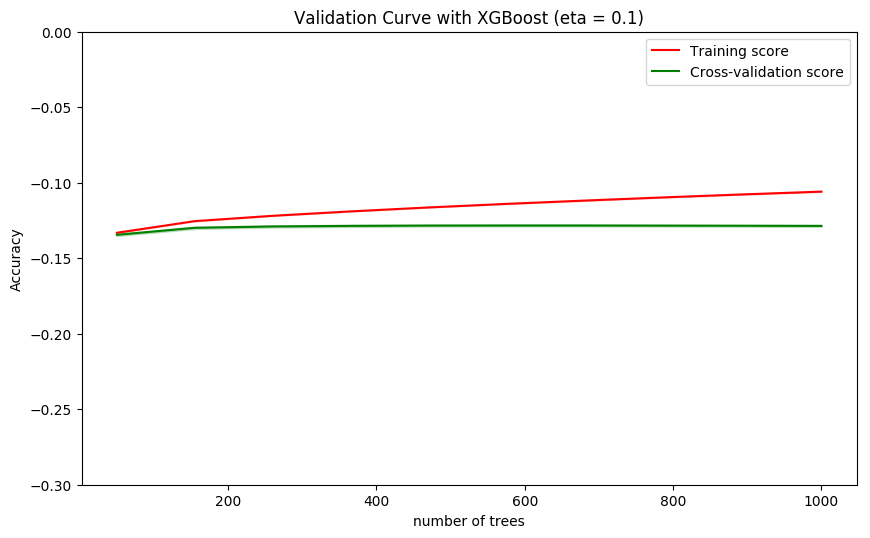

Best cross-validation result (-0.13) obtained for 577 trees


In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6), dpi=100)
# plot
plt.title("Validation Curve with XGBoost (eta = 0.1)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(-0.3, 0)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

best_i = np.argmax(test_scores_mean) # best index

'''
The model need to be trained 10(parameters_range) * 3 (K-fold = 10) : 30 
Notice: 先初步找到range of n_estimators, In the end of hyperparameters tuning, 
we should lower the learning rate and add more trees. 
'''

print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[best_i], n_estimators_range[best_i]))


In [25]:
[i for i in range(3,10,2)]

[3, 5, 7, 9]

In [27]:
from sklearn.grid_search import GridSearchCV
############################
#1. Start with wider range 
############################
param_test1 = {
 'max_depth':[i for i in range(3,10,2)], # star from 3 and end at 9 with step 2. For example, [3,5,7,9]
 'min_child_weight':[i for i in range(1,6,2)] # [1,3,5]
}
fixed_estimator = 577

cv = StratifiedKFold(Y_train, n_folds=3, shuffle=True, random_state=72)
'''
Here we trained 12(parameters combinations) * 3 (K-fold = 3) : 36 models

'''
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
	n_estimators = fixed_estimator, 
	max_depth=5,
 	min_child_weight=1, 
 	gamma=0, 
 	subsample=0.8, 
 	colsample_bytree=0.8,
 	objective= 'binary:logistic', 
 	nthread=4, 
 	scale_pos_weight=1, 
 	seed=seed), 
 	param_grid = param_test1, 
 	scoring='neg_log_loss',
 	n_jobs=4,
 	cv=cv)
# running
gsearch1.fit(X_train, Y_train)

print ('results',gsearch1.grid_scores_)
print ('best paras',gsearch1.best_params_)



results [mean: -0.13348, std: 0.00071, params: {'max_depth': 3, 'min_child_weight': 1}, mean: -0.13355, std: 0.00064, params: {'max_depth': 3, 'min_child_weight': 3}, mean: -0.13350, std: 0.00065, params: {'max_depth': 3, 'min_child_weight': 5}, mean: -0.12897, std: 0.00063, params: {'max_depth': 5, 'min_child_weight': 1}, mean: -0.12908, std: 0.00061, params: {'max_depth': 5, 'min_child_weight': 3}, mean: -0.12910, std: 0.00063, params: {'max_depth': 5, 'min_child_weight': 5}, mean: -0.12823, std: 0.00059, params: {'max_depth': 7, 'min_child_weight': 1}, mean: -0.12817, std: 0.00053, params: {'max_depth': 7, 'min_child_weight': 3}, mean: -0.12811, std: 0.00058, params: {'max_depth': 7, 'min_child_weight': 5}, mean: -0.13003, std: 0.00066, params: {'max_depth': 9, 'min_child_weight': 1}, mean: -0.12932, std: 0.00061, params: {'max_depth': 9, 'min_child_weight': 3}, mean: -0.12898, std: 0.00059, params: {'max_depth': 9, 'min_child_weight': 5}]
best paras {'max_depth': 7, 'min_child_weig

'\nHere we trained 12(parameters combinations) * 5 (K-fold = 3) : 50 models\n'

In [28]:
gsearch1.best_params_['max_depth']

7

In [30]:
gsearch1.best_params_['min_child_weight'] 

5

In [31]:
############################
#2. Lets go one step deeper(interval = 1) and look for optimum values.
############################

param_test2 = {
 'max_depth':[gsearch1.best_params_['max_depth'] - 1, gsearch1.best_params_['max_depth'], gsearch1.best_params_['max_depth'] + 1],
 'min_child_weight':[gsearch1.best_params_['min_child_weight'] - 1, gsearch1.best_params_['min_child_weight'], gsearch1.best_params_['min_child_weight'] + 1]
}
'''

Here we trained 9(parameters combinations) * 3 (K-fold = 3) : 27 models


'''
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
	n_estimators = fixed_estimator, 
	max_depth=5,
 	min_child_weight=1, 
 	gamma=0, 
 	subsample=0.8, 
 	colsample_bytree=0.8,
 	objective= 'binary:logistic', 
 	nthread=4, 
 	scale_pos_weight=1, 
 	seed=seed), 
 	param_grid = param_test2, 
 	scoring='neg_log_loss',
 	n_jobs=4,
 	cv=cv)
# running
gsearch2.fit(X_train, Y_train)

print ('results',gsearch2.grid_scores_)
print ('best paras',gsearch2.best_params_)
print ('best_score_',gsearch2.best_score_)


results [mean: -0.12826, std: 0.00055, params: {'max_depth': 6, 'min_child_weight': 4}, mean: -0.12830, std: 0.00059, params: {'max_depth': 6, 'min_child_weight': 5}, mean: -0.12829, std: 0.00063, params: {'max_depth': 6, 'min_child_weight': 6}, mean: -0.12808, std: 0.00057, params: {'max_depth': 7, 'min_child_weight': 4}, mean: -0.12811, std: 0.00058, params: {'max_depth': 7, 'min_child_weight': 5}, mean: -0.12813, std: 0.00065, params: {'max_depth': 7, 'min_child_weight': 6}, mean: -0.12842, std: 0.00060, params: {'max_depth': 8, 'min_child_weight': 4}, mean: -0.12838, std: 0.00064, params: {'max_depth': 8, 'min_child_weight': 5}, mean: -0.12836, std: 0.00057, params: {'max_depth': 8, 'min_child_weight': 6}]
best paras {'max_depth': 7, 'min_child_weight': 4}
best_score_ -0.12807966623946077


'\n\nHere we trained 9(parameters combinations) * 3 (K-fold = 3) : 27 models\n\nNotice that:\n\n'

In [37]:
'''

g1: best_score_ -0.12810652765349884

g2: best_score_ -0.12807966623946077 (Compared to g1, model inded get slightly inprovement)

'''

gsearch2.best_params_['min_child_weight']

4

In [38]:
##########################################
#Step 2: Tune gamma
##########################################
'''
gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree.
The values depend on the loss function and should be tuned.

Higher values make the algorithm conservative.
'''
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)] # [0, 0.1, 0.2, 0.3, 0.4]
}
'''

Here we trained 5(parameters combinations) * 3 (K-fold = 3) : 15 models


'''
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
	n_estimators = fixed_estimator, 
	max_depth = gsearch2.best_params_['max_depth'],
 	min_child_weight= gsearch2.best_params_['min_child_weight'], 
 	gamma=0, 
 	subsample=0.8, 
 	colsample_bytree=0.8,
 	objective= 'binary:logistic', 
 	nthread=4, 
 	scale_pos_weight=1, 
 	seed=seed), 
 	param_grid = param_test3, 
 	scoring='neg_log_loss',
 	n_jobs=4,
 	cv=cv)
# running
gsearch3.fit(X_train, Y_train)

print ('results',gsearch3.grid_scores_)
print ('best paras',gsearch3.best_params_)
print ('best_score_',gsearch3.best_score_)

results [mean: -0.12808, std: 0.00057, params: {'gamma': 0.0}, mean: -0.12812, std: 0.00063, params: {'gamma': 0.1}, mean: -0.12822, std: 0.00058, params: {'gamma': 0.2}, mean: -0.12813, std: 0.00063, params: {'gamma': 0.3}, mean: -0.12815, std: 0.00062, params: {'gamma': 0.4}]
best paras {'gamma': 0.0}
best_score_ -0.12807966623946077


In [39]:
gsearch3.best_params_['gamma']

0.0

In [40]:
##########################################
#Step 4: Tune subsample and colsample_bytree
##########################################

'''
The reason we tune the two parameters is to add randomness for making training robust to noise

subsample: subsample ratio of the training instance.
colsample_bytree: subsample ratio of columns for each split, in each level.

We'll tune this in 2 stages.
1. To begin with, take values 0.6,0.7,0.8,0.9 for both to start with.
2. Secondly, Now we should try values in 0.05 interval around optimum values we found above.
'''

############################
#1. Start with wider range 
############################
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)], # [0,6, 0,7, 0.8, 0.9]
 'colsample_bytree':[i/10.0 for i in range(6,10)] # [0,6, 0,7, 0.8, 0.9]
}
'''
Here we trained 16(parameters combinations) * 3 (K-fold = 3) : 48 models

'''
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
	n_estimators = fixed_estimator, 
	max_depth= gsearch2.best_params_['max_depth'],
 	min_child_weight= gsearch2.best_params_['min_child_weight'], 
 	gamma= gsearch3.best_params_['gamma'], 
 	subsample=0.8, 
 	colsample_bytree=0.8,
 	objective= 'binary:logistic', 
 	nthread=4, 
 	scale_pos_weight=1, 
 	seed=seed), 
 	param_grid = param_test4, 
 	scoring='neg_log_loss',
 	n_jobs=4,
 	cv=cv)
# running
gsearch4.fit(X_train, Y_train)

print ('results',gsearch4.grid_scores_)
print ('best paras',gsearch4.best_params_)
print ('best_score_',gsearch4.best_score_)


results [mean: -0.12872, std: 0.00060, params: {'colsample_bytree': 0.6, 'subsample': 0.6}, mean: -0.12838, std: 0.00062, params: {'colsample_bytree': 0.6, 'subsample': 0.7}, mean: -0.12803, std: 0.00066, params: {'colsample_bytree': 0.6, 'subsample': 0.8}, mean: -0.12787, std: 0.00062, params: {'colsample_bytree': 0.6, 'subsample': 0.9}, mean: -0.12862, std: 0.00053, params: {'colsample_bytree': 0.7, 'subsample': 0.6}, mean: -0.12834, std: 0.00063, params: {'colsample_bytree': 0.7, 'subsample': 0.7}, mean: -0.12810, std: 0.00065, params: {'colsample_bytree': 0.7, 'subsample': 0.8}, mean: -0.12787, std: 0.00069, params: {'colsample_bytree': 0.7, 'subsample': 0.9}, mean: -0.12862, std: 0.00063, params: {'colsample_bytree': 0.8, 'subsample': 0.6}, mean: -0.12842, std: 0.00065, params: {'colsample_bytree': 0.8, 'subsample': 0.7}, mean: -0.12808, std: 0.00057, params: {'colsample_bytree': 0.8, 'subsample': 0.8}, mean: -0.12789, std: 0.00064, params: {'colsample_bytree': 0.8, 'subsample': 0

In [44]:
[gsearch4.best_params_['subsample']-0.05 ,gsearch4.best_params_['subsample'], gsearch4.best_params_['subsample'] + 0.05]

[0.85, 0.9, 0.9500000000000001]

In [45]:
############################
#2. Lets go one step deeper(interval = 0.05) and look for optimum values.
############################
param_test5 = {
 'subsample':[gsearch4.best_params_['subsample']-0.05 ,gsearch4.best_params_['subsample'], gsearch4.best_params_['subsample'] + 0.05], # [0.85, 0.9, 0.95] 
 'colsample_bytree':[gsearch4.best_params_['colsample_bytree']-0.05 ,gsearch4.best_params_['colsample_bytree'], gsearch4.best_params_['colsample_bytree'] + 0.05] # # [0.65, 0.7, 0.75] 
}

'''
Here we trained 9(parameters combinations) * 3 (K-fold = 3) : 9 models

'''
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
	n_estimators = fixed_estimator, 
	max_depth= gsearch2.best_params_['max_depth'],
 	min_child_weight= gsearch2.best_params_['min_child_weight'], 
 	gamma= gsearch3.best_params_['gamma'], 
 	subsample=0.8, 
 	colsample_bytree= 0.8,
 	objective= 'binary:logistic', 
 	nthread=4, 
 	scale_pos_weight=1, 
 	seed=seed), 
 	param_grid = param_test5, 
 	scoring='neg_log_loss',
 	n_jobs=4,
 	cv=cv)
# running
gsearch5.fit(X_train, Y_train)

print ('results',gsearch5.grid_scores_)
print ('best paras',gsearch5.best_params_)
print ('best_score_',gsearch5.best_score_)

results [mean: -0.12810, std: 0.00070, params: {'colsample_bytree': 0.6499999999999999, 'subsample': 0.85}, mean: -0.12786, std: 0.00067, params: {'colsample_bytree': 0.6499999999999999, 'subsample': 0.9}, mean: -0.12784, std: 0.00063, params: {'colsample_bytree': 0.6499999999999999, 'subsample': 0.9500000000000001}, mean: -0.12803, std: 0.00064, params: {'colsample_bytree': 0.7, 'subsample': 0.85}, mean: -0.12787, std: 0.00069, params: {'colsample_bytree': 0.7, 'subsample': 0.9}, mean: -0.12788, std: 0.00063, params: {'colsample_bytree': 0.7, 'subsample': 0.9500000000000001}, mean: -0.12804, std: 0.00067, params: {'colsample_bytree': 0.75, 'subsample': 0.85}, mean: -0.12788, std: 0.00067, params: {'colsample_bytree': 0.75, 'subsample': 0.9}, mean: -0.12779, std: 0.00062, params: {'colsample_bytree': 0.75, 'subsample': 0.9500000000000001}]
best paras {'colsample_bytree': 0.75, 'subsample': 0.9500000000000001}
best_score_ -0.1277880892465591


In [47]:
gsearch5.best_params_['colsample_bytree']

0.75

In [52]:
############################
#2. Lets go one step deeper(interval = 0.05) and look for optimum values.
############################
param_test6 = {
 'subsample':[1.0]
}
'''
Here we trained 1(parameters combinations) * 3 (K-fold = 3) : 3 models

'''
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
	n_estimators = fixed_estimator, 
	max_depth= gsearch2.best_params_['max_depth'],
 	min_child_weight= gsearch2.best_params_['min_child_weight'], 
 	gamma= gsearch3.best_params_['gamma'], 
 	subsample=0.8, 
 	colsample_bytree= gsearch5.best_params_['colsample_bytree'],
 	objective= 'binary:logistic', 
 	nthread=4, 
 	scale_pos_weight=1, 
 	seed=seed), 
 	param_grid = param_test6, 
 	scoring='neg_log_loss',
 	n_jobs=4,
 	cv=cv)
# running
gsearch6.fit(X_train, Y_train)

print ('results',gsearch6.grid_scores_)
print ('best paras',gsearch6.best_params_)
print ('best_score_',gsearch6.best_score_)

results [mean: -0.12780, std: 0.00069, params: {'subsample': 1.0}]
best paras {'subsample': 1.0}
best_score_ -0.1277976053088933


In [53]:
-0.1277880892465591 > -0.1277976053088933

True

In [55]:
##########################################
#Step 5: Tuning Regularization Parameters
##########################################

'''
lambda[default = 1]: L2 regularization term on weights, increase this value will make model more conservative.
alphad[efault = 0]: L1 regularization term on weights, increase this value will make model more conservative.

Theoretically, L1 is more unstable than L2.

'''
param_test7 = {
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 10, 100]
}


gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
	n_estimators = fixed_estimator, 
	max_depth= gsearch2.best_params_['max_depth'],
 	min_child_weight= gsearch2.best_params_['min_child_weight'], 
 	gamma= gsearch3.best_params_['gamma'], 
 	subsample = 0.95, 
 	colsample_bytree = 0.75,
 	objective= 'binary:logistic', 
 	nthread=4, 
 	scale_pos_weight=1, 
 	seed=seed), 
 	param_grid = param_test7, 
 	scoring='neg_log_loss',
 	n_jobs=4,
 	cv=cv)
# running
gsearch7.fit(X_train, Y_train)

print ('results',gsearch7.grid_scores_)
print ('best paras',gsearch7.best_params_)
print ('best_score_',gsearch7.best_score_)


results [mean: -0.12792, std: 0.00075, params: {'reg_lambda': 1e-05}, mean: -0.12784, std: 0.00065, params: {'reg_lambda': 0.01}, mean: -0.12789, std: 0.00063, params: {'reg_lambda': 0.1}, mean: -0.12779, std: 0.00062, params: {'reg_lambda': 1}, mean: -0.12811, std: 0.00054, params: {'reg_lambda': 100}]
best paras {'reg_lambda': 1}
best_score_ -0.1277880892465591


In [65]:
print (0.1/2)

0.05


In [ ]:
############################
#2. Lets go smaller interval centering around the above optimum.
############################
param_test8 = {
 'reg_lambda':[0.1, 0.5, 1,10]
}


gsearch8 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
	n_estimators = fixed_estimator, 
	max_depth= gsearch2.best_params_['max_depth'],
 	min_child_weight= gsearch2.best_params_['min_child_weight'], 
 	gamma= gsearch3.best_params_['gamma'], 
 	subsample = 0.95, 
 	colsample_bytree = 0.75,
 	objective= 'binary:logistic', 
 	nthread=4, 
 	scale_pos_weight=1, 
 	seed=seed,
    reg_lambda=1), 
 	param_grid = param_test8, 
 	scoring='neg_log_loss',
 	n_jobs=4,
 	cv=cv)
# running
gsearch8.fit(X_train, Y_train)

print ('results',gsearch8.grid_scores_)
print ('best paras',gsearch8.best_params_)
print ('best_score_',gsearch8.best_score_)

In [68]:
print ('results',gsearch8.grid_scores_)
print ('best paras',gsearch8.best_params_)
print ('best_score_',gsearch8.best_score_)

results [mean: -0.12789, std: 0.00063, params: {'reg_lambda': 0.1}, mean: -0.12788, std: 0.00065, params: {'reg_lambda': 0.5}, mean: -0.12779, std: 0.00062, params: {'reg_lambda': 1}, mean: -0.12778, std: 0.00065, params: {'reg_lambda': 10}]
best paras {'reg_lambda': 10}
best_score_ -0.1277819217394043


In [69]:
############################
#3. Lets go smaller interval centering around the above optimum all over again
############################
param_test9 = {
 'reg_lambda':[2.5 , 5, 7.5]
}


gsearch9 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
	n_estimators = fixed_estimator, 
	max_depth= gsearch2.best_params_['max_depth'],
 	min_child_weight= gsearch2.best_params_['min_child_weight'], 
 	gamma= gsearch3.best_params_['gamma'], 
 	subsample = 0.95, 
 	colsample_bytree = 0.75,
 	objective= 'binary:logistic', 
 	nthread=4, 
 	scale_pos_weight=1, 
 	seed=seed,
    reg_lambda=1), 
 	param_grid = param_test9, 
 	scoring='neg_log_loss',
 	n_jobs=4,
 	cv=cv)
# running
gsearch9.fit(X_train, Y_train)

print ('results',gsearch9.grid_scores_)
print ('best paras',gsearch9.best_params_)
print ('best_score_',gsearch9.best_score_)

results [mean: -0.12777, std: 0.00067, params: {'reg_lambda': 2.5}, mean: -0.12775, std: 0.00072, params: {'reg_lambda': 5}, mean: -0.12776, std: 0.00066, params: {'reg_lambda': 7.5}]
best paras {'reg_lambda': 5}
best_score_ -0.12774503424335962


In [70]:
gsearch2.best_params_['max_depth']

7

In [71]:
gsearch2.best_params_['min_child_weight']

4

In [72]:
gsearch3.best_params_['gamma']

0.0